In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import yfinance as yf
from yahoo_fin.stock_info import get_earnings_history
from fredapi import Fred
from dotenv import load_dotenv
import os
import pandas_datareader as web
import lightgbm as lgb
import shap
from datetime import datetime,timedelta
import pickle
import gbdt_module as mod
from varname import nameof


In [2]:
#From yahoo
sp_500 = yf.download(tickers="^GSPC",start="1995-01-01",interval="1d")
#Download data from FRED API
load_dotenv() #Create environment variable
API_KEY = os.getenv("API_KEY") #Get API_KEY from .env file
fred = Fred(api_key = API_KEY)
###*****Don't change order of the series names*****###
series_fred = ['BAMLC0A0CM','BAMLH0A0HYM2','DCOILWTICO','DTB3','DGS5','DGS10','DGS30','T5YIE','T10YIE','T10Y2Y','T10Y3M','VIXCLS','DEXUSEU','DEXJPUS','DEXUSUK','DEXCHUS']
start_fred = '1/1/1995'
ticker_yf = '^GSPC'
start_yf = '1995-01-01'
interval='1d'
series_names = ['ig_spread','hy_spread','wti','treas_3m','treas_5y','treas_10y','treas_30y','binf_5y','binf_10y','y10_y2','y10_m3','vix','eur','jpy','gbp','cny']

fred_series,sp_data = mod.download_data(fred,series_fred,start_fred,ticker_yf,start_yf,interval,series_names)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
""" Features:
1. S&P 500 returns variance - 5 day,10 day and 21 day
2. IG and HY spread
3. Change in IG and HY spread in bps
4. Change in crude oil prices
5. 3m,5y,10y and 30y yields
6. Change in 3m,5y,10y,30y in bps
7. 5y and 10y breakeven inflation
8. Change in 5y,10y breakeven in bps
9. 2s10s,3m10s
10. Change in 2s10s,3m10s
11. VIX and change in VIX
12. Change in currencies
"""
data_0,feature_num,sp_return5,sp_return10,sp_return15 = mod.derive_features(fred_series,sp_data)


In [ ]:
########################################################## Light GBM ###############################################################################

In [4]:
#Create target series
percentile_list = [5,10,15,20,25]
y_5d = mod.create_target_series(sp_return5,percentile_list,f_horizon=5)
y_10d = mod.create_target_series(sp_return10,percentile_list,f_horizon=10)
y_15d = mod.create_target_series(sp_return15,percentile_list,f_horizon=15)
#Reindex features data
data_5d = mod.reindex_features_data(data_0,5,y_5d)
data_10d = mod.reindex_features_data(data_0,10,y_10d)
data_15d = mod.reindex_features_data(data_0,15,y_15d)
#Create feature list
f_names = ['sp_var5','sp_var10','sp_var21','ig_spread','ig_change','hy_spread','hy_change','wti_change','treas3m_change','treas5y_change','treas10y_change','treas30y_change','binf5_change','binf10_change','y10_y2','y10_m3','y10_m3change','y10_y2change','vix_change','eur_change','jpy_change','gbp_change','cny_change']
features_names = pd.DataFrame(f_names,feature_num)


In [ ]:
############################################################# 5 -day ahead model ########################################################################

In [5]:
#Train-test split
train_size,valid_size,test_size = mod.data_split_size(data_5d,0.75)
x_train,y_train,x_valid,y_valid,x_test,y_test = mod.data_split(data_5d,y_5d,train_size,valid_size,test_size)

[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.19251
[2]	training's binary_logloss: 0.186934
[3]	training's binary_logloss: 0.182129
[4]	training's binary_logloss: 0.177951
[5]	training's binary_logloss: 0.174661
[6]	training's binary_logloss: 0.171586
[7]	training's binary_logloss: 0.169015
[8]	training's binary_logloss: 0.166752
[9]	training's binary_logloss: 0.164816
[10]	training's binary_logloss: 0.162619
Training - The ROC AUC of model's prediction is: 0.8657316693592613
Validation - The ROC AUC of model's predict

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


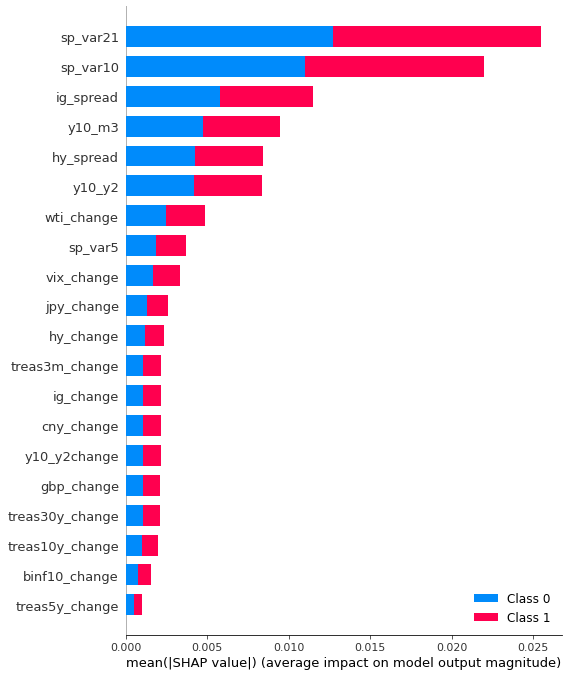

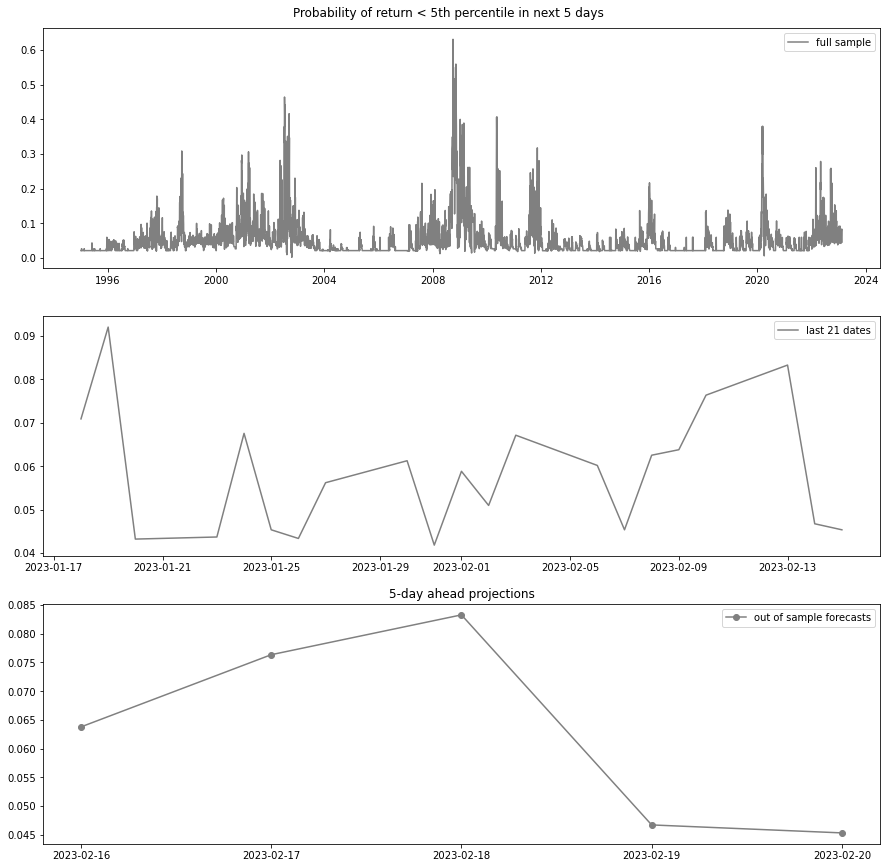

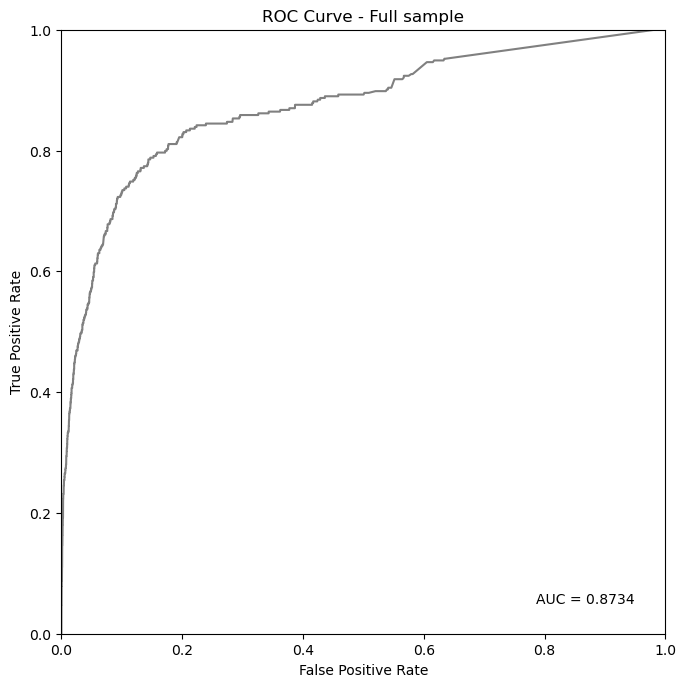

In [6]:
#col_index = 0 (5 percentile),1 (10 percentile),2 (15 percentile),3 (20 percentile),4 (25 percentile)
params = mod.params_5d1
mod.train_test_pickle(x_train,x_valid,y_train,y_valid,x_test,y_test,col_index=0,num_boost=10,f_horizon=5,params=params,feature_num=feature_num,model_name = 'model_5d1',full_sample_data = data_5d,full_sample_y = y_5d,full_data = data_0,f_names = f_names,percentile= 5)


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.19251
[2]	training's binary_logloss: 0.186934
[3]	training's binary_logloss: 0.182129
[4]	training's binary_logloss: 0.177951
[5]	training's binary_logloss: 0.174661
[6]	training's binary_logloss: 0.171586
[7]	training's binary_logloss: 0.169015
[8]	training's binary_logloss: 0.166752
[9]	training's binary_logloss: 0.164816
[10]	training's binary_logloss: 0.162619
Training - The ROC AUC of model's prediction is: 0.8657316693592613
Validation - The ROC AUC of model's predict

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.330385
[2]	training's binary_logloss: 0.325634
[3]	training's binary_logloss: 0.320586
[4]	training's binary_logloss: 0.31699
[5]	training's binary_logloss: 0.313171
[6]	training's binary_logloss: 0.309821
[7]	training's binary_logloss: 0.306739
[8]	training's binary_logloss: 0.30421
[9]	training's binary_logloss: 0.301513
[10]	training's binary_logloss: 0.299381
Training - The ROC AUC of model's prediction is: 0.7936445661250651
Validation - The ROC AUC of model's predicti

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.430552
[2]	training's binary_logloss: 0.426008
[3]	training's binary_logloss: 0.421547
[4]	training's binary_logloss: 0.417706
[5]	training's binary_logloss: 0.414507
[6]	training's binary_logloss: 0.410956
[7]	training's binary_logloss: 0.407835
[8]	training's binary_logloss: 0.404345
[9]	training's binary_logloss: 0.401647
[10]	training's binary_logloss: 0.398924
Training - The ROC AUC of model's prediction is: 0.768913130851327
Validation - The ROC AUC of model's predict

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.512739
[2]	training's binary_logloss: 0.507949
[3]	training's binary_logloss: 0.503781
[4]	training's binary_logloss: 0.499986
[5]	training's binary_logloss: 0.496794
[6]	training's binary_logloss: 0.493331
[7]	training's binary_logloss: 0.490386
[8]	training's binary_logloss: 0.487484
[9]	training's binary_logloss: 0.48535
[10]	training's binary_logloss: 0.482579
Training - The ROC AUC of model's prediction is: 0.7510504951605829
Validation - The ROC AUC of model's predict

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.573078
[2]	training's binary_logloss: 0.569183
[3]	training's binary_logloss: 0.565539
[4]	training's binary_logloss: 0.562062
[5]	training's binary_logloss: 0.558967
[6]	training's binary_logloss: 0.556154
[7]	training's binary_logloss: 0.553508
[8]	training's binary_logloss: 0.550876
[9]	training's binary_logloss: 0.547687
[10]	training's binary_logloss: 0.544806
Training - The ROC AUC of model's prediction is: 0.7379066469016508
Validation - The ROC AUC of model's predic

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.188218
[2]	training's binary_logloss: 0.182097
[3]	training's binary_logloss: 0.177544
[4]	training's binary_logloss: 0.173742
[5]	training's binary_logloss: 0.170451
[6]	training's binary_logloss: 0.166556
[7]	training's binary_logloss: 0.163095
[8]	training's binary_logloss: 0.160508
[9]	training's binary_logloss: 0.158032
[10]	training's binary_logloss: 0.155913
Training - The ROC AUC of model's prediction is: 0.8833069228860606
Validation - The ROC AUC of model's predic

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.318285
[2]	training's binary_logloss: 0.311496
[3]	training's binary_logloss: 0.305443
[4]	training's binary_logloss: 0.300835
[5]	training's binary_logloss: 0.296334
[6]	training's binary_logloss: 0.292205
[7]	training's binary_logloss: 0.288735
[8]	training's binary_logloss: 0.285525
[9]	training's binary_logloss: 0.282541
[10]	training's binary_logloss: 0.279834
Training - The ROC AUC of model's prediction is: 0.8217994816743911
Validation - The ROC AUC of model's predic

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.428034
[2]	training's binary_logloss: 0.421128
[3]	training's binary_logloss: 0.414881
[4]	training's binary_logloss: 0.409487
[5]	training's binary_logloss: 0.40444
[6]	training's binary_logloss: 0.40037
[7]	training's binary_logloss: 0.396333
[8]	training's binary_logloss: 0.392633
[9]	training's binary_logloss: 0.389616
[10]	training's binary_logloss: 0.386598
Training - The ROC AUC of model's prediction is: 0.7958857205951954
Validation - The ROC AUC of model's predicti

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.51215
[2]	training's binary_logloss: 0.506421
[3]	training's binary_logloss: 0.50049
[4]	training's binary_logloss: 0.495352
[5]	training's binary_logloss: 0.490744
[6]	training's binary_logloss: 0.485864
[7]	training's binary_logloss: 0.48145
[8]	training's binary_logloss: 0.477788
[9]	training's binary_logloss: 0.474135
[10]	training's binary_logloss: 0.470464
Training - The ROC AUC of model's prediction is: 0.7927642391395746
Validation - The ROC AUC of model's predictio

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.572359
[2]	training's binary_logloss: 0.566643
[3]	training's binary_logloss: 0.561631
[4]	training's binary_logloss: 0.556286
[5]	training's binary_logloss: 0.551786
[6]	training's binary_logloss: 0.547249
[7]	training's binary_logloss: 0.542495
[8]	training's binary_logloss: 0.538283
[9]	training's binary_logloss: 0.534261
[10]	training's binary_logloss: 0.530462
Training - The ROC AUC of model's prediction is: 0.788738671681114
Validation - The ROC AUC of model's predict

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.190607
[2]	training's binary_logloss: 0.181778
[3]	training's binary_logloss: 0.174574
[4]	training's binary_logloss: 0.169775
[5]	training's binary_logloss: 0.165853
[6]	training's binary_logloss: 0.161497
[7]	training's binary_logloss: 0.157712
[8]	training's binary_logloss: 0.154183
[9]	training's binary_logloss: 0.151416
[10]	training's binary_logloss: 0.148346
Training - The ROC AUC of model's prediction is: 0.923465698295919
Validation - The ROC AUC of model's predict

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.318936
[2]	training's binary_logloss: 0.309788
[3]	training's binary_logloss: 0.301982
[4]	training's binary_logloss: 0.295419
[5]	training's binary_logloss: 0.290466
[6]	training's binary_logloss: 0.285107
[7]	training's binary_logloss: 0.280921
[8]	training's binary_logloss: 0.276186
[9]	training's binary_logloss: 0.272099
[10]	training's binary_logloss: 0.268379
Training - The ROC AUC of model's prediction is: 0.8577103434845973
Validation - The ROC AUC of model's predic

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.423345
[2]	training's binary_logloss: 0.41581
[3]	training's binary_logloss: 0.4085
[4]	training's binary_logloss: 0.402129
[5]	training's binary_logloss: 0.39663
[6]	training's binary_logloss: 0.390303
[7]	training's binary_logloss: 0.385623
[8]	training's binary_logloss: 0.38107
[9]	training's binary_logloss: 0.377135
[10]	training's binary_logloss: 0.37334
Training - The ROC AUC of model's prediction is: 0.8218900182646539
Validation - The ROC AUC of model's prediction i

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.506294
[2]	training's binary_logloss: 0.498095
[3]	training's binary_logloss: 0.490618
[4]	training's binary_logloss: 0.484079
[5]	training's binary_logloss: 0.478513
[6]	training's binary_logloss: 0.472826
[7]	training's binary_logloss: 0.46737
[8]	training's binary_logloss: 0.46257
[9]	training's binary_logloss: 0.458553
[10]	training's binary_logloss: 0.454465
Training - The ROC AUC of model's prediction is: 0.7705377022174746
Validation - The ROC AUC of model's predicti

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Unknown parameter: bossting_type
[LightGBM] [Warning] Unknown parameter: ojective
[LightGBM] [Warning] Unknown parameter: is_training_mteric
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[1]	training's binary_logloss: 0.569849
[2]	training's binary_logloss: 0.5625
[3]	training's binary_logloss: 0.555989
[4]	training's binary_logloss: 0.549707
[5]	training's binary_logloss: 0.54417
[6]	training's binary_logloss: 0.538921
[7]	training's binary_logloss: 0.533517
[8]	training's binary_logloss: 0.528285
[9]	training's binary_logloss: 0.523679
[10]	training's binary_logloss: 0.519553
Training - The ROC AUC of model's prediction is: 0.7871861713682772
Validation - The ROC AUC of model's predictio

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


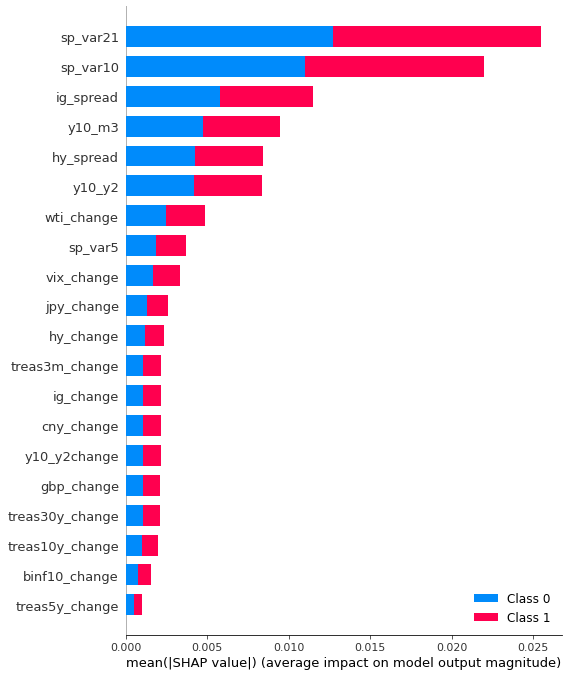

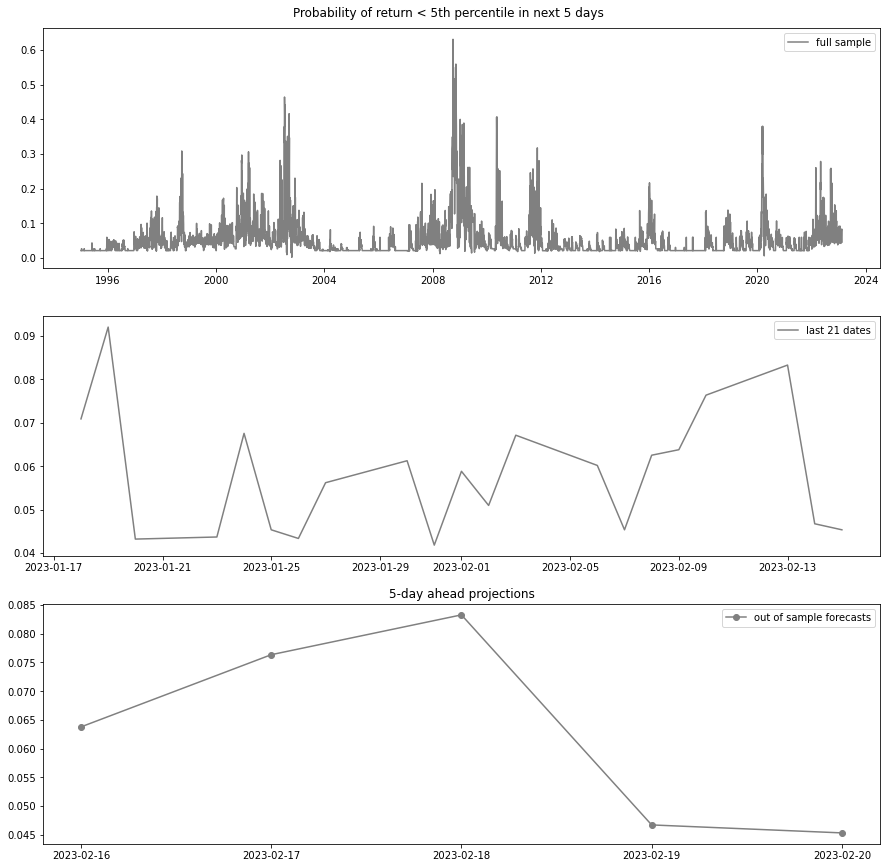

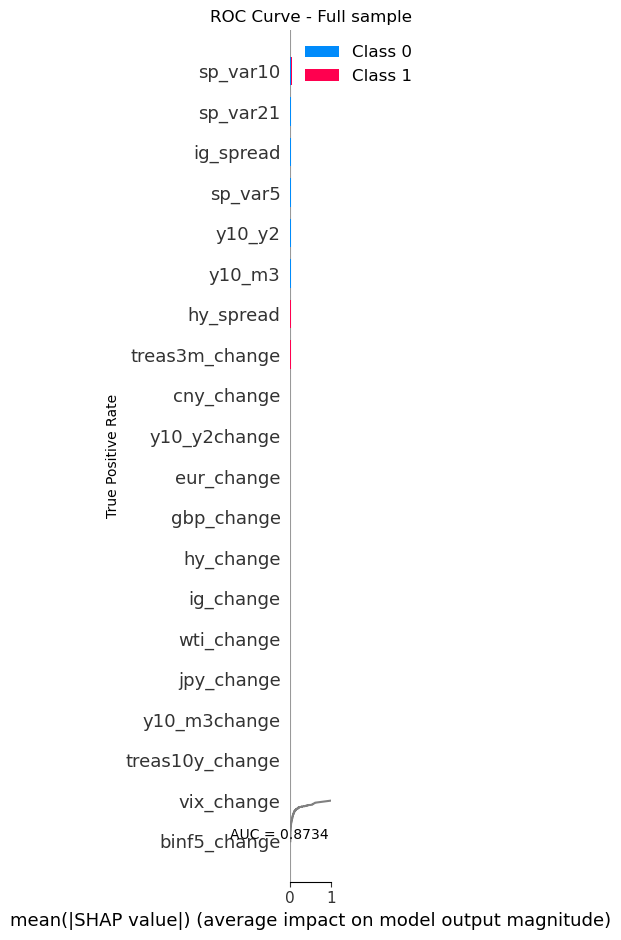

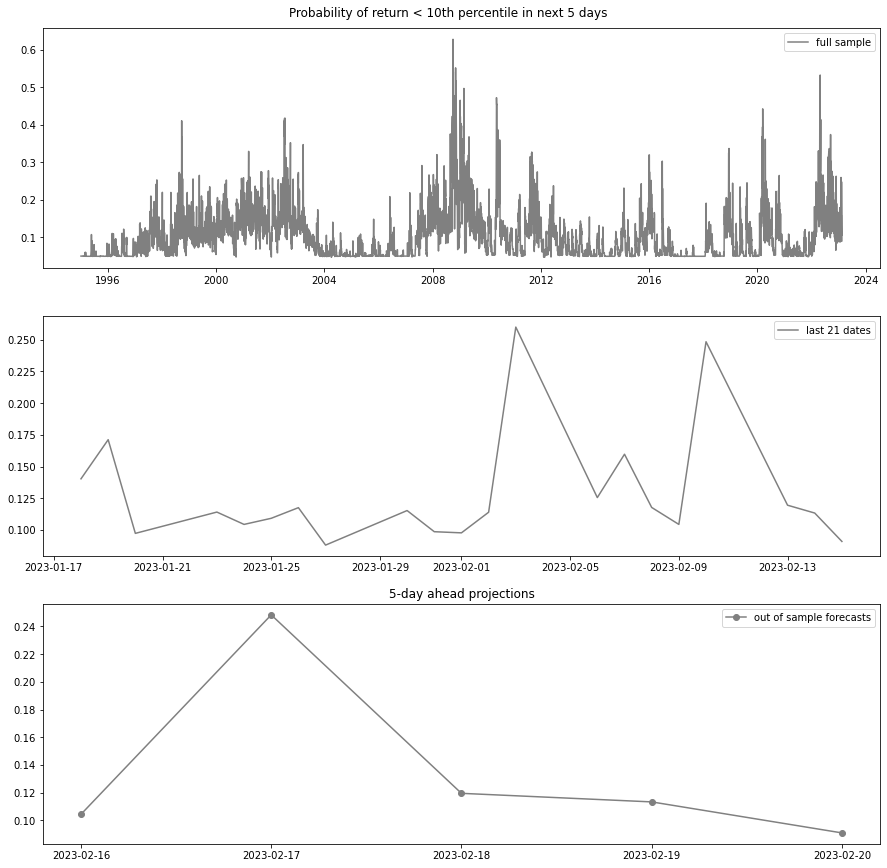

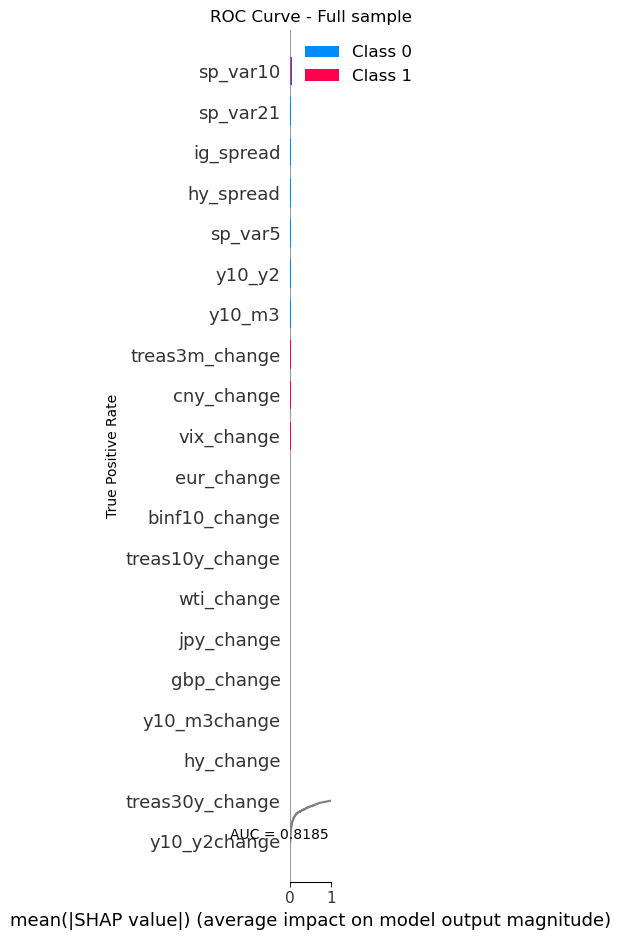

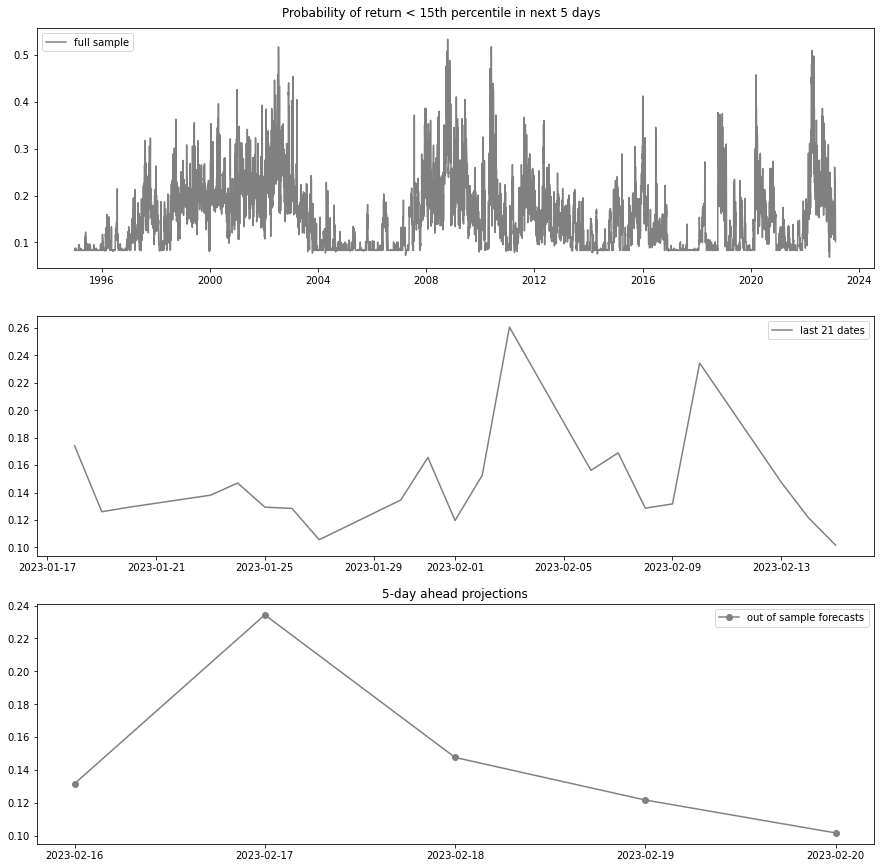

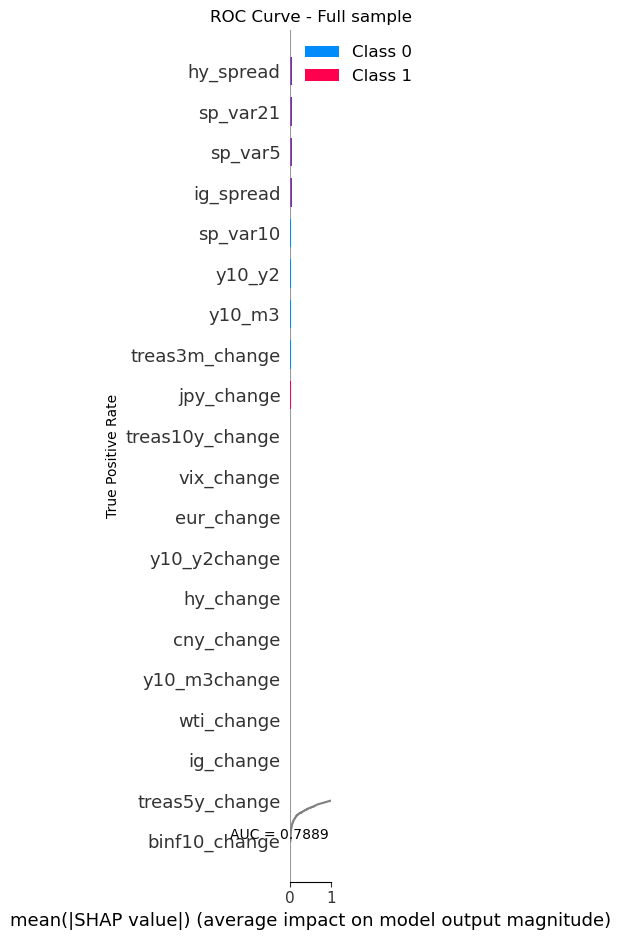

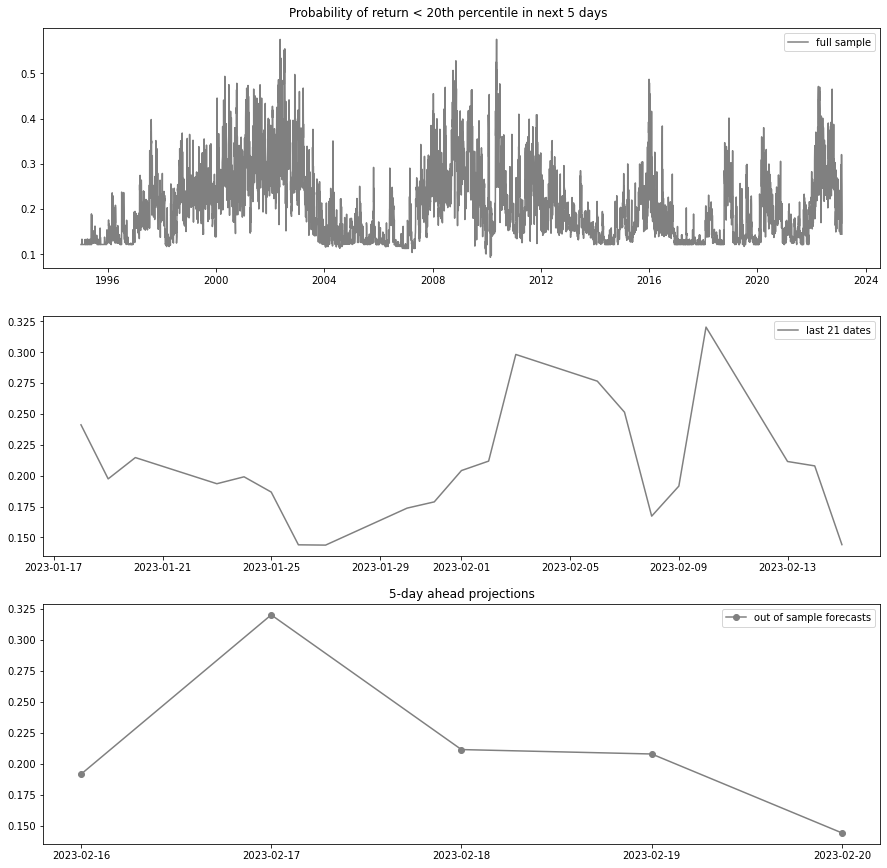

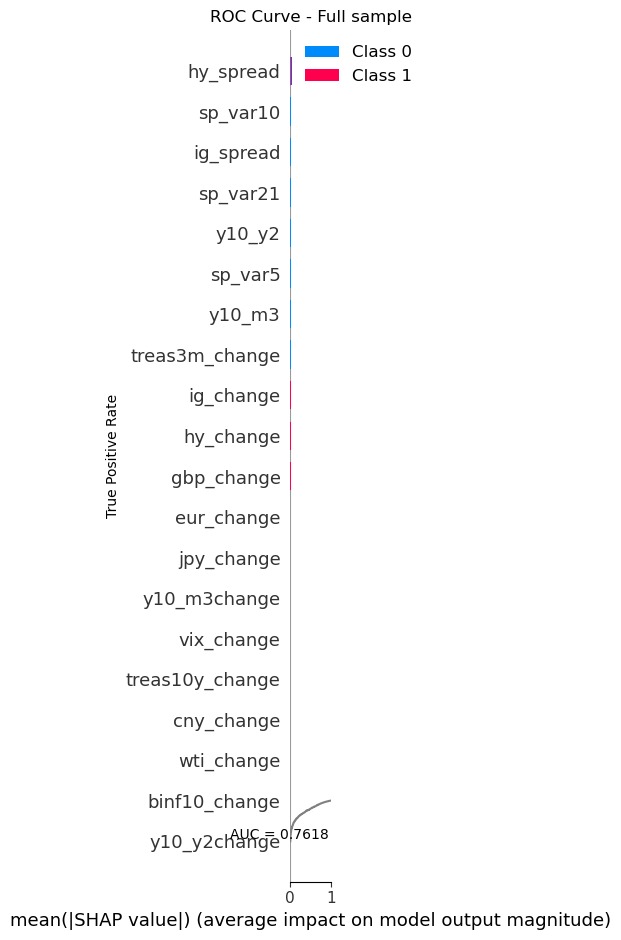

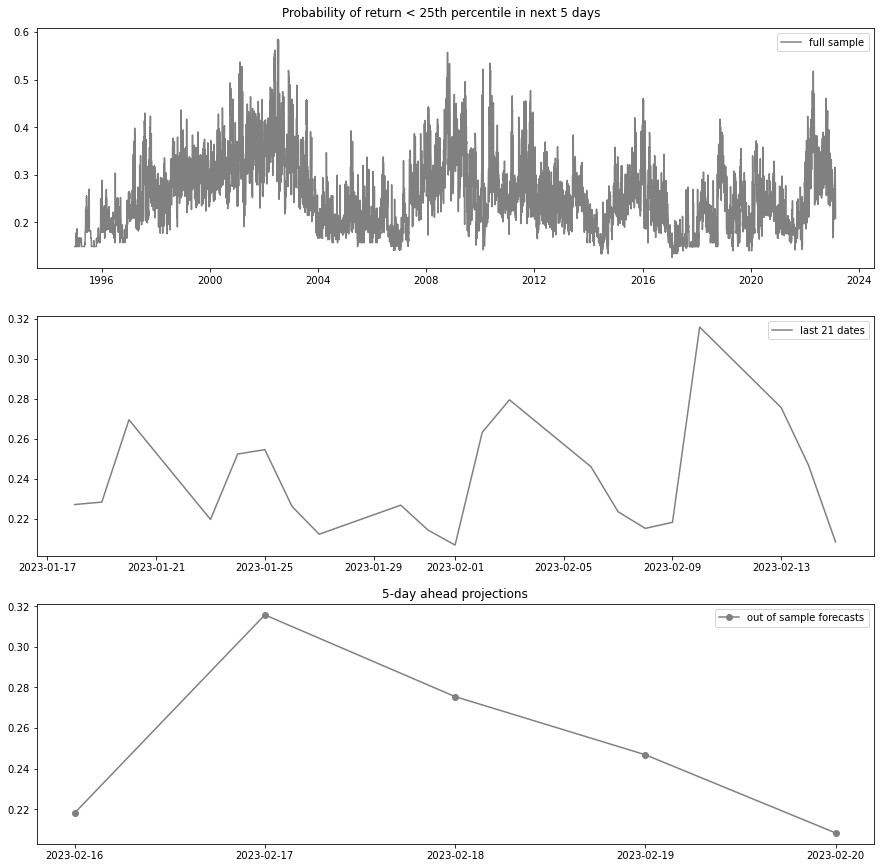

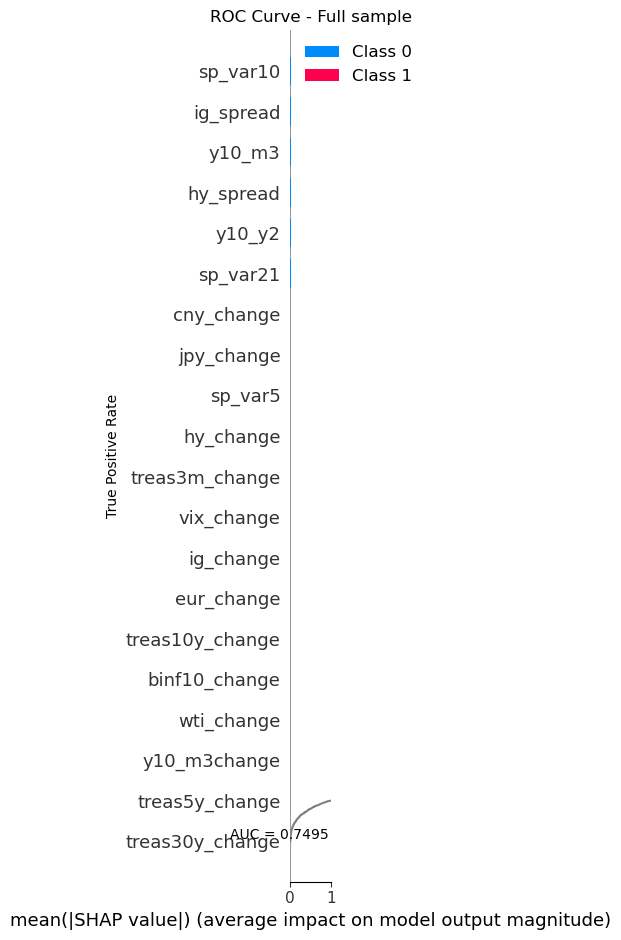

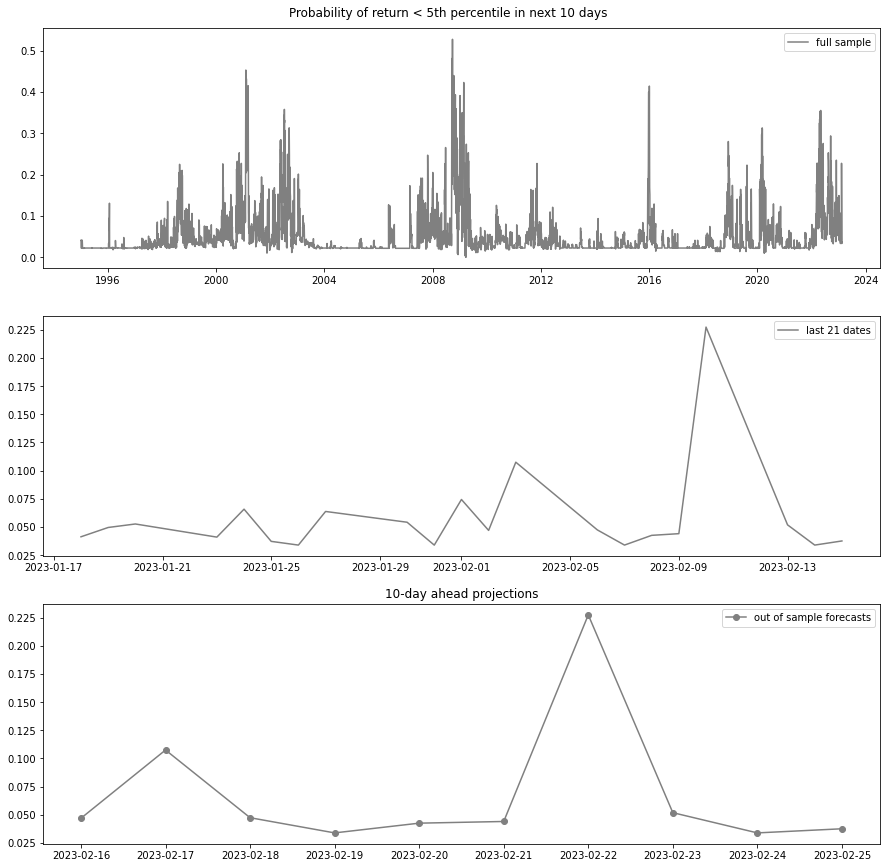

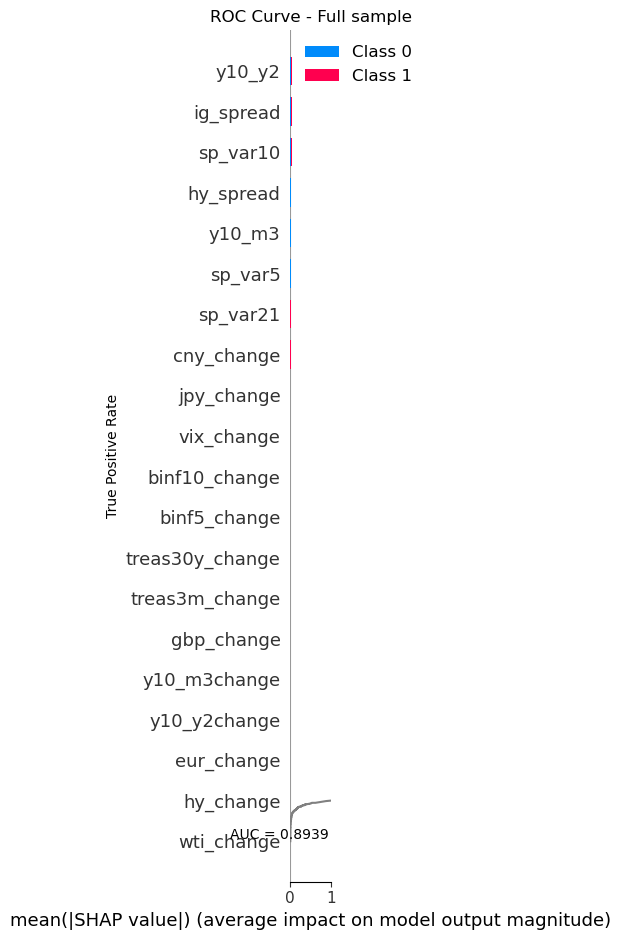

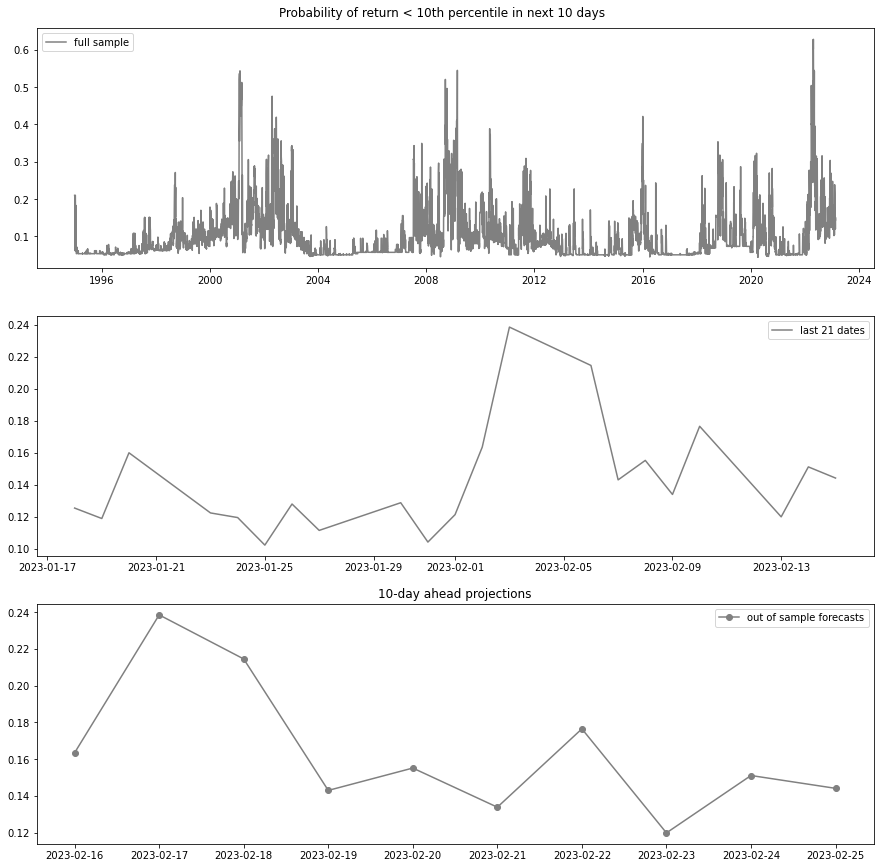

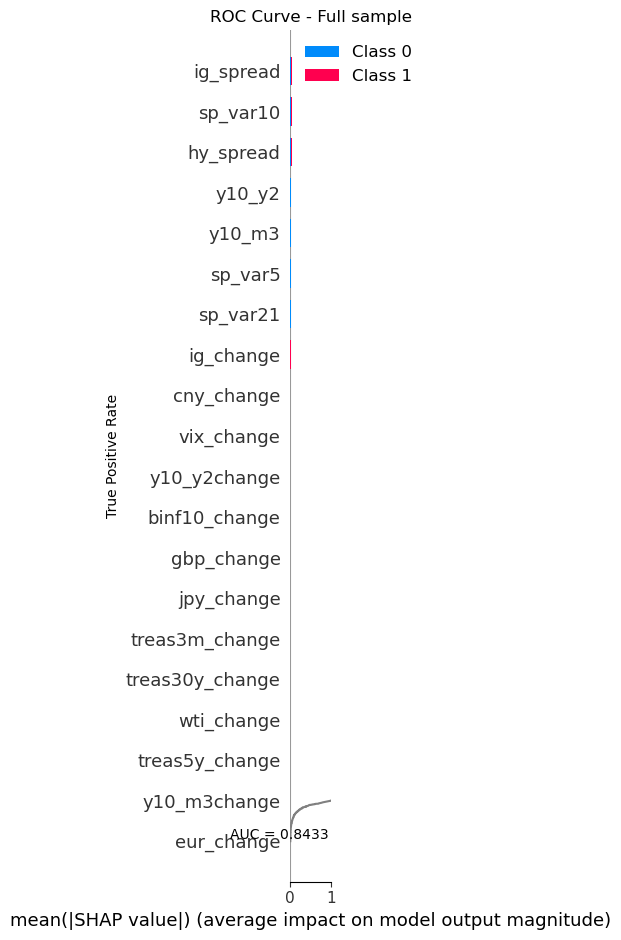

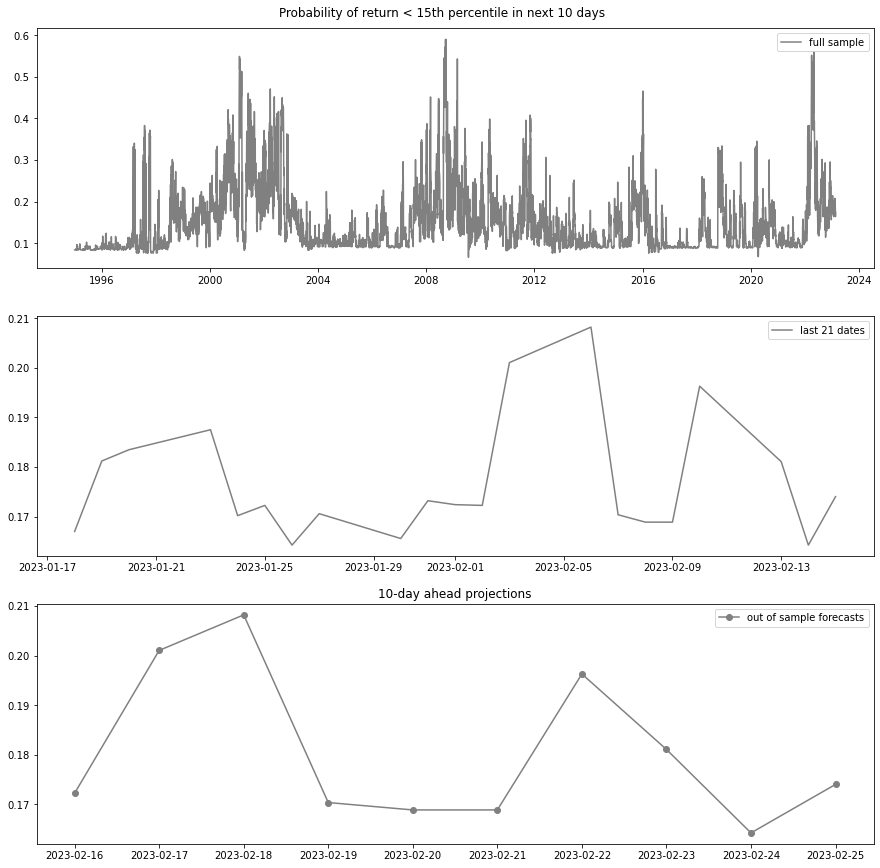

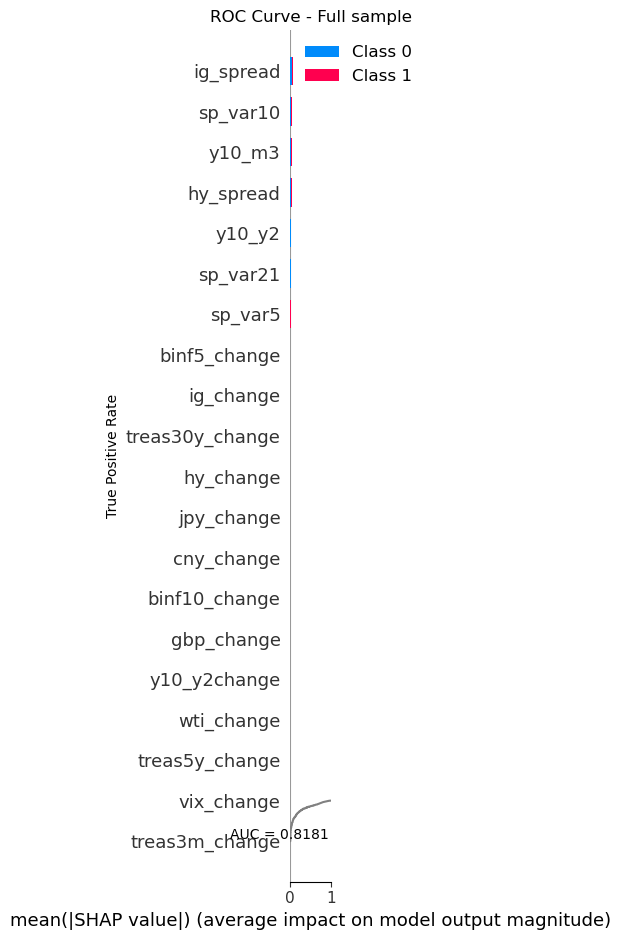

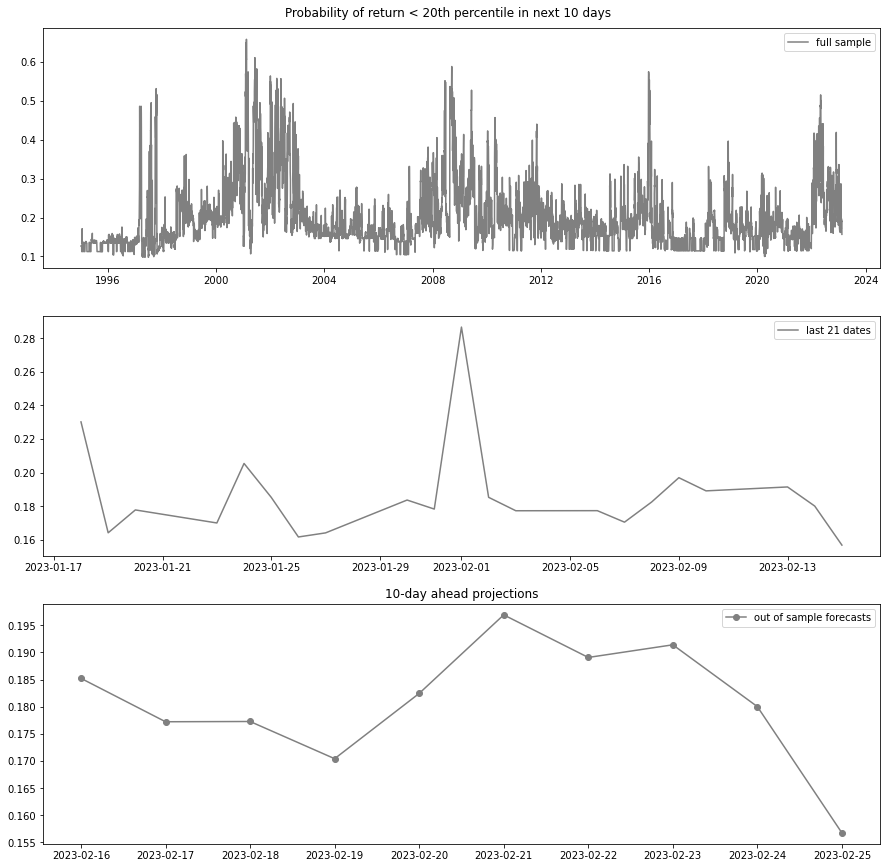

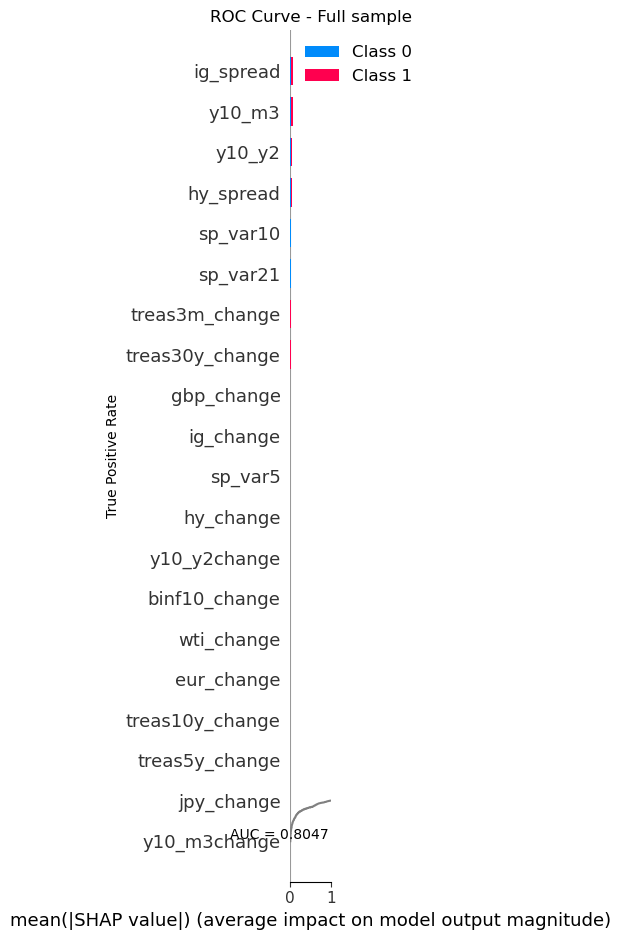

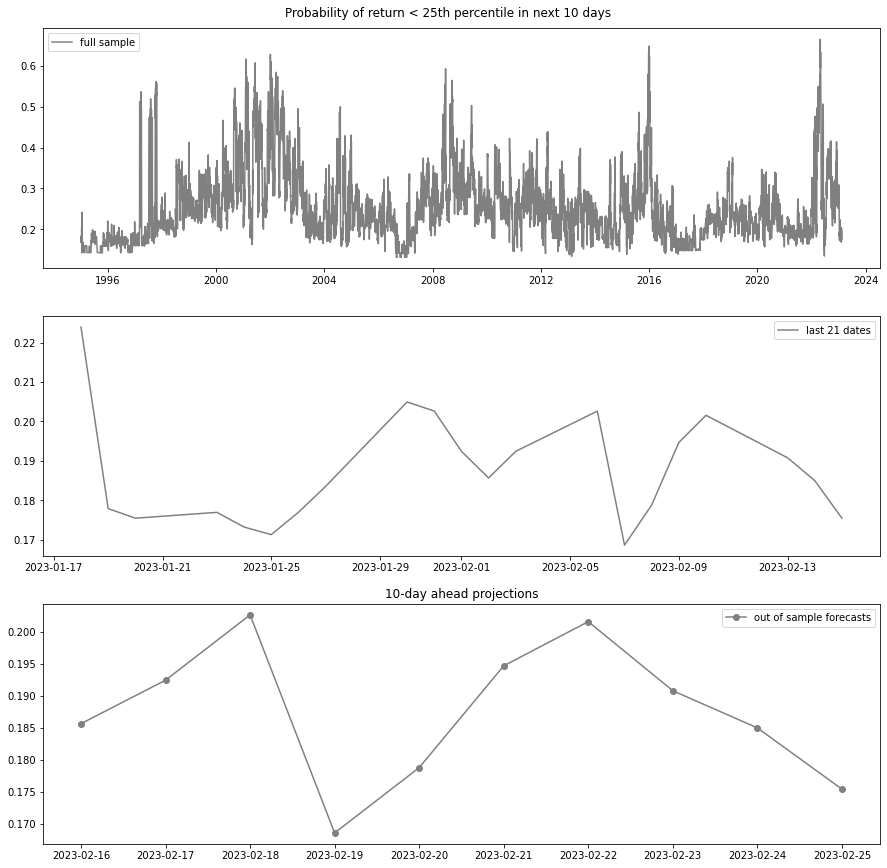

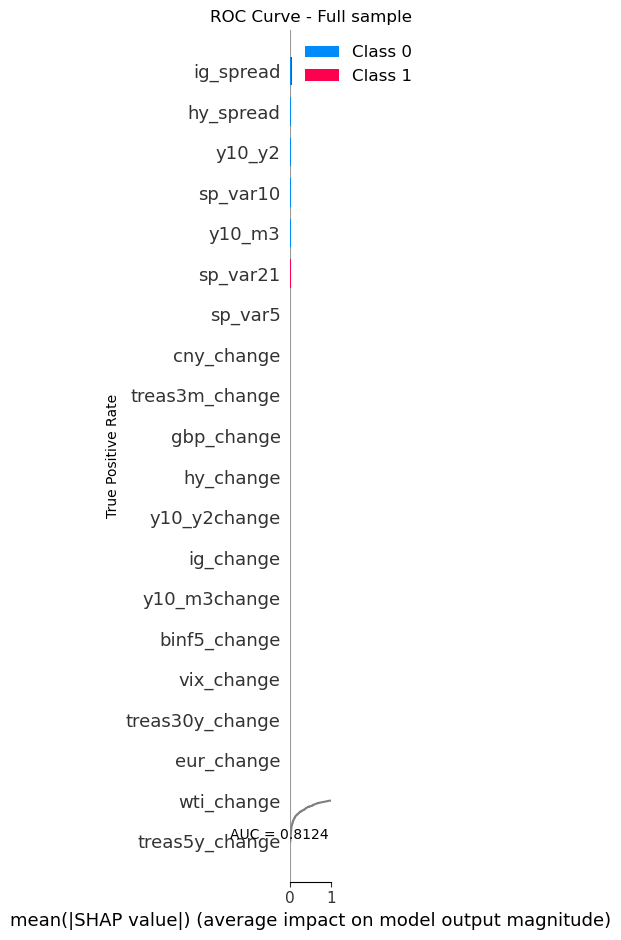

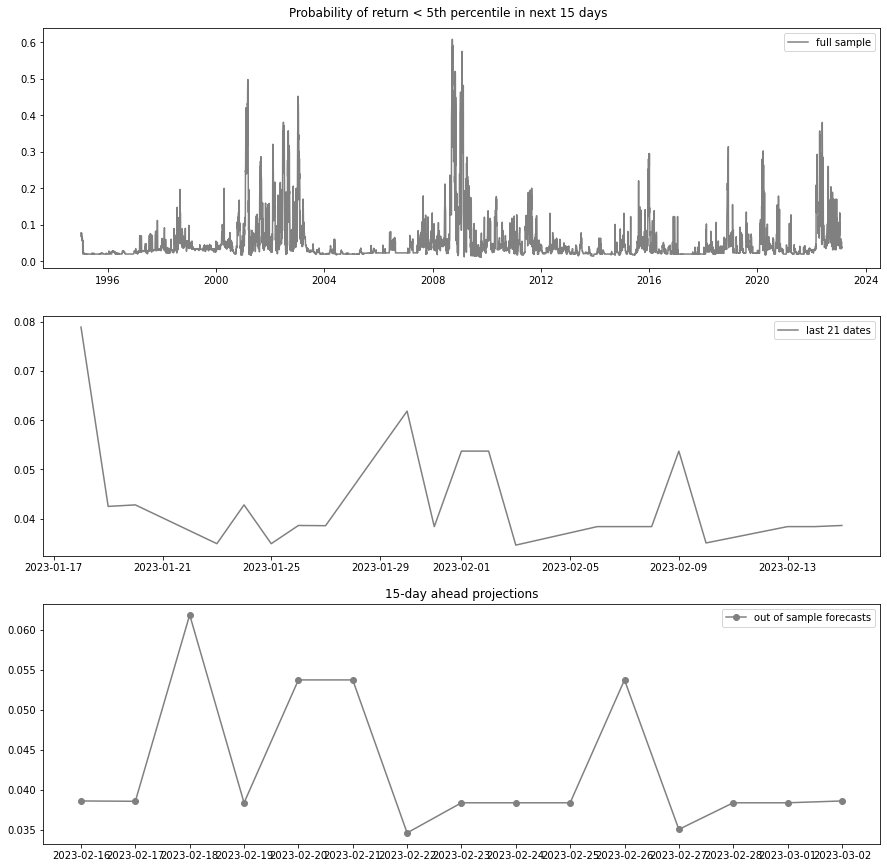

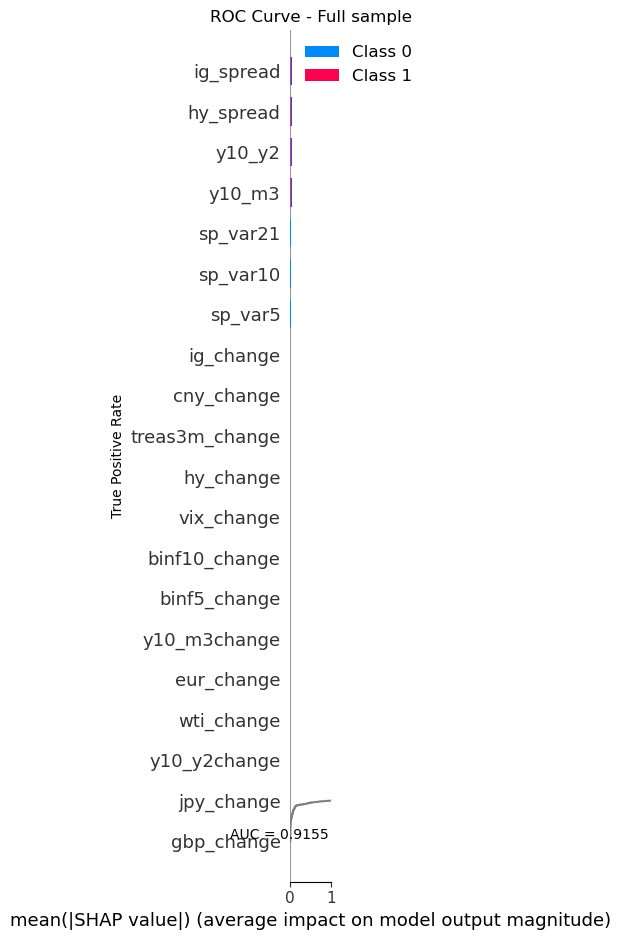

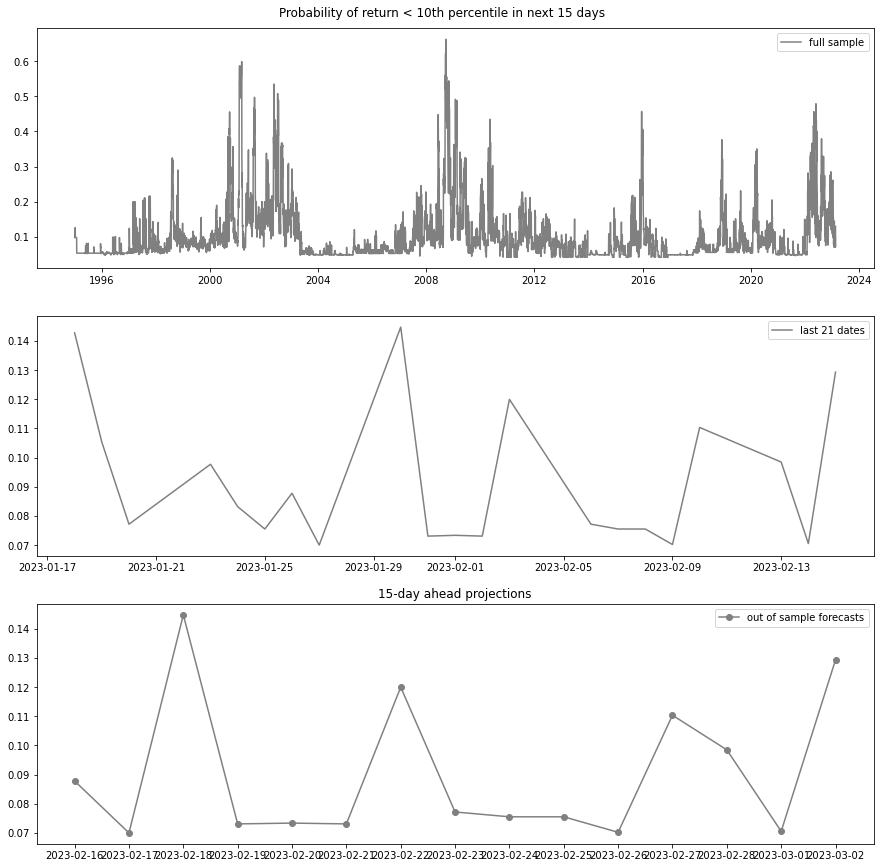

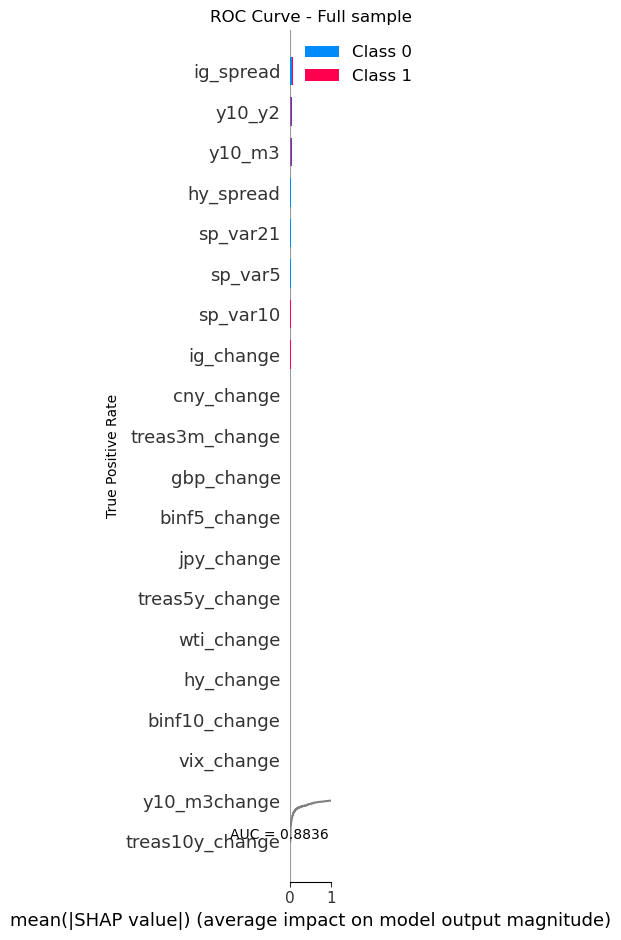

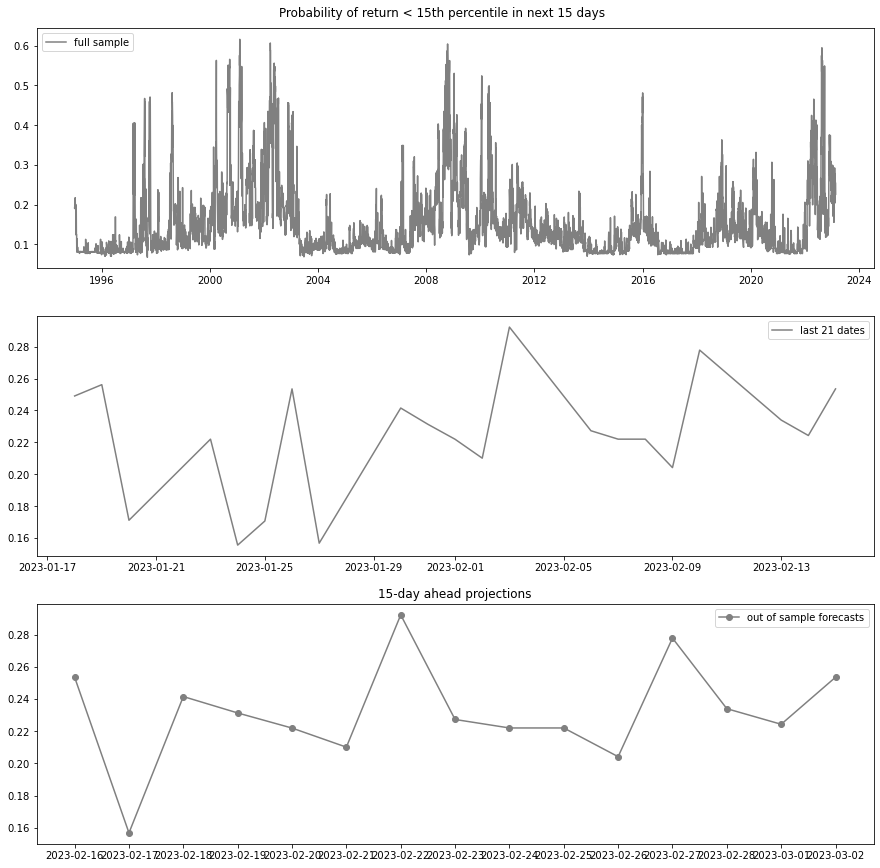

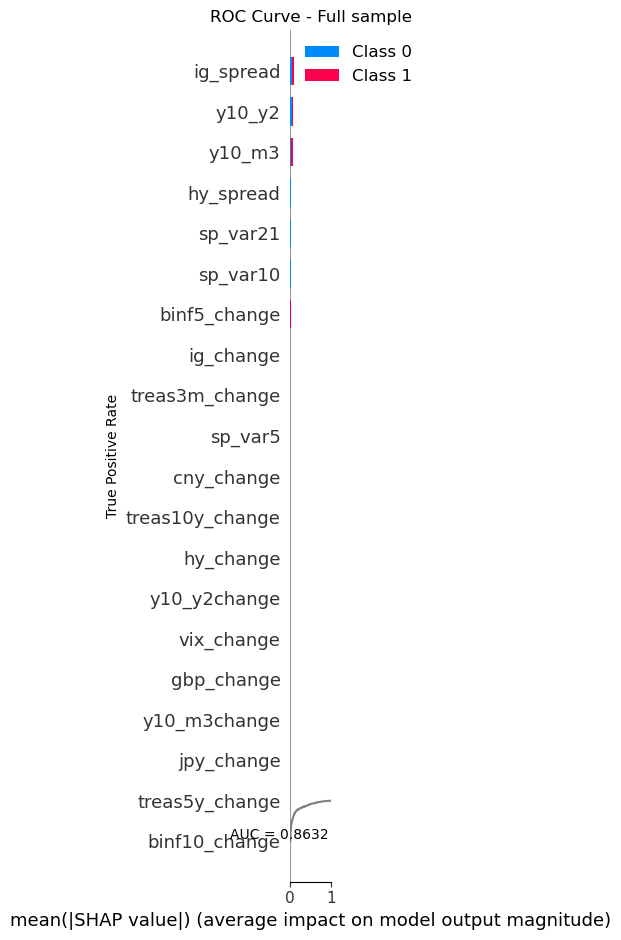

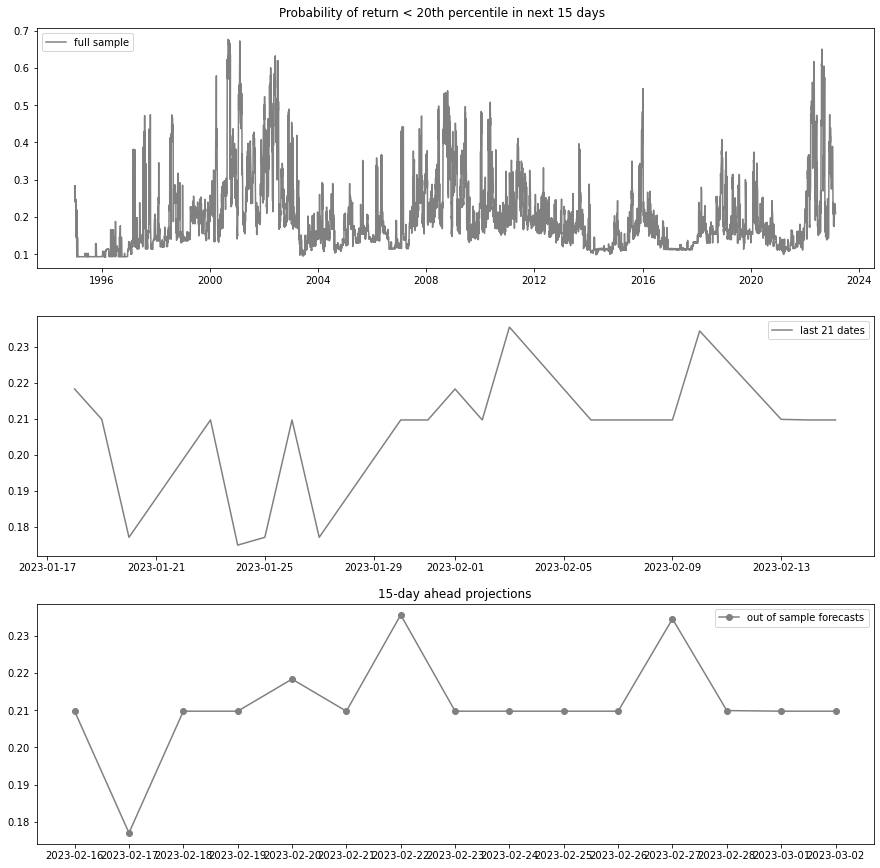

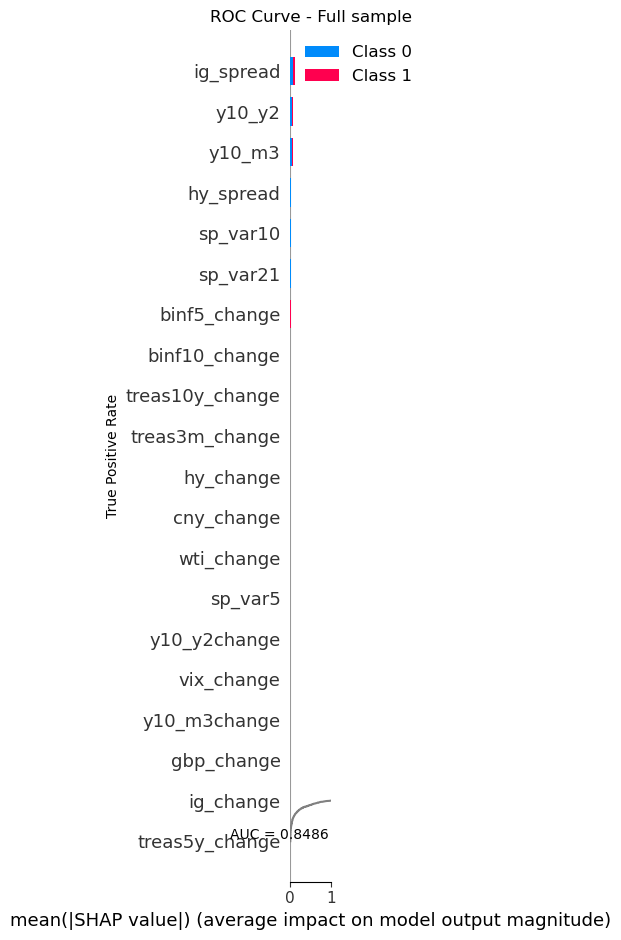

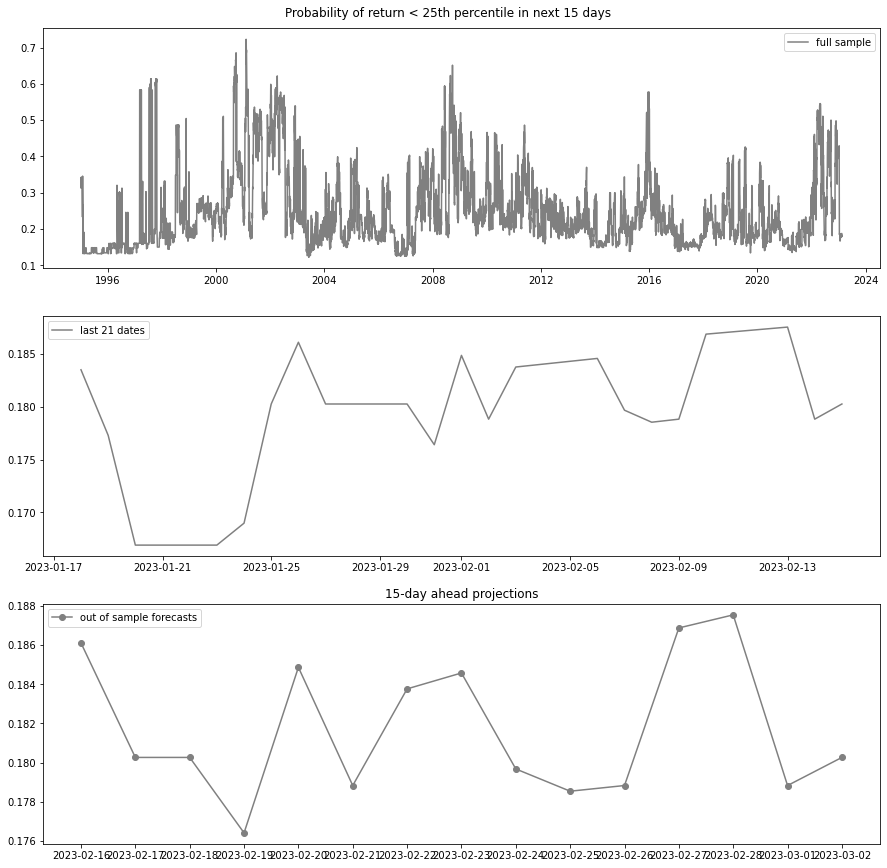

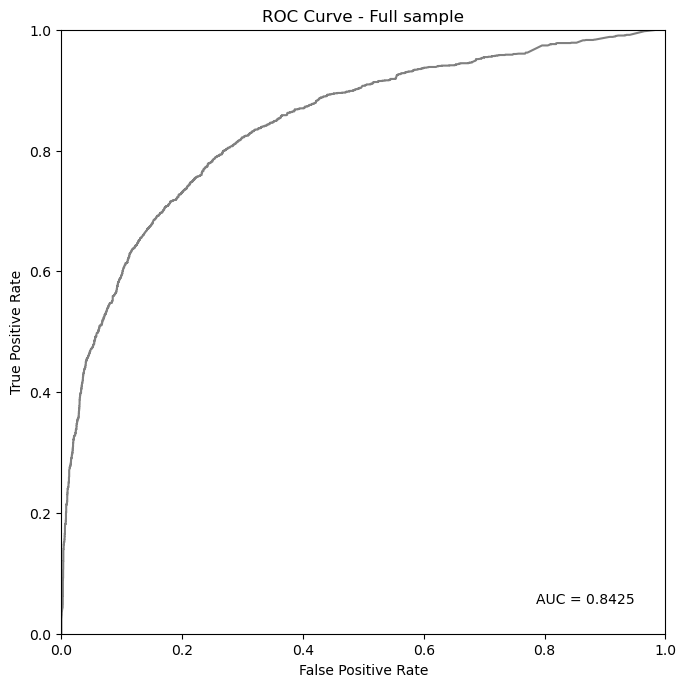

In [16]:
x_data = [data_5d,data_10d,data_15d]
targets_list = [y_5d,y_10d,y_15d]
horizon_list = [5,10,15]
percentile_list = [5,10,15,20,25]
full_data=data_0
params = mod.params_5d1

for x_data,y_data,f_horizon in zip(x_data,targets_list,horizon_list):
    for col_index,percentile in zip(range(5),percentile_list):
        model_name = 'model_' + str(f_horizon) + 'd'+ str(col_index+1)
        train_size,valid_size,test_size = mod.data_split_size(x_data,0.75)
        x_train,y_train,x_valid,y_valid,x_test,y_test = mod.data_split(x_data,y_data,train_size,valid_size,test_size)
        mod.train_test_pickle(x_train,x_valid,y_train,y_valid,x_test,y_test,col_index=col_index,num_boost=10,f_horizon=f_horizon,params=params,feature_num=feature_num,model_name = model_name,full_sample_data = x_data,full_sample_y = y_data,full_data = full_data,f_names = f_names,percentile=percentile)

'5d'